In [1]:
import yfinance
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from scipy.special import inv_boxcox

import warnings
warnings.filterwarnings('ignore')

In [2]:
ticker = yfinance.Ticker("AAPL")
historical_data = ticker.history(period='5y')
df = pd.DataFrame(historical_data)
df = df.reset_index().dropna()
close_prices = np.array(df['Close'])
dates = np.array(df["Date"])

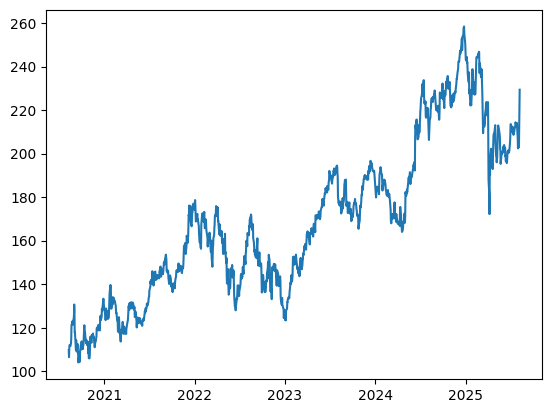

In [3]:
plt.plot(dates, close_prices)
plt.show()

In [4]:
for i in close_prices:
    if i<0:
        print(i)

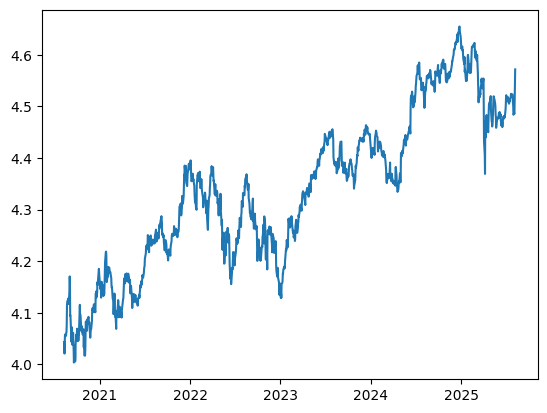

-0.06561461624475744


In [5]:
from scipy.stats import boxcox

# Ensure all values are positive (required for boxcox)
if np.any(close_prices < 0):
	raise ValueError("All values in close_prices must be positive for Box-Cox transformation.")

boxcox_prices, lam = boxcox(close_prices)
plt.clf()
plt.plot(dates, boxcox_prices)
plt.show()
print(lam)

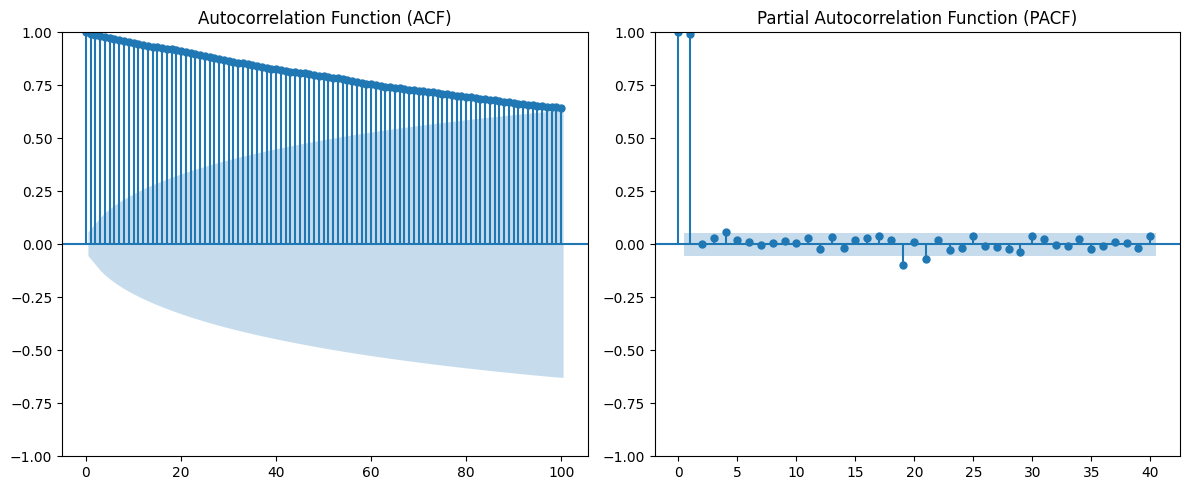

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_acf(boxcox_prices, lags=100, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

# Plot PACF (shows correlation between current value and specific lag after removing effects of shorter lags)
plt.subplot(1, 2, 2)
plot_pacf(boxcox_prices, lags=40, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [7]:
best_aic = np.inf
best_order = None
best_model = None

p_values = range(0, 10)
d_values = range(0, 2)
q_values = range(0, 10)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                model = ARIMA(train, order=(p, d, q))
                model_fit = model.fit()
                aic = model_fit.aic
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = model_fit
            except:
                continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

Best ARIMA order: None with AIC: inf


Started...
Step: 0
Step: 50
Step: 100
Step: 150
Step: 200
Step: 250
Step: 300
Step: 350
Error: 2.128878580704188


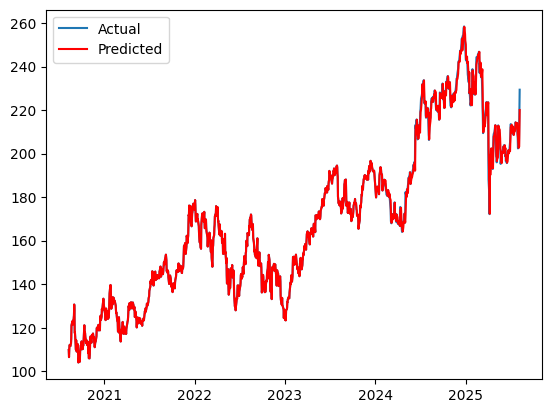

In [10]:
train_split = int(0.7*len(boxcox_prices))
train = boxcox_prices[:train_split]
test = boxcox_prices[train_split:]


p,d,q = 4, 1, 2

box_predictions = []

history = list(train)

print("Started...")

for i in range(len(test)):
    if i %50 == 0:
        print(f"Step: {i}")
    model = ARIMA(history, order=(p,d,q))
    modeled = model.fit()
    box_predictions.append(modeled.forecast(steps=1)[0])
    history.append(test[i])

predictions = inv_boxcox(box_predictions,lam)
pred = list(close_prices[:train_split]) + list(predictions)

rmse = sqrt(mean_squared_error(close_prices, pred))
print(f"Error: {rmse}")

plt.clf()

plt.plot(dates, close_prices, label='Actual')
plt.plot(dates, pred, label='Predicted', color='red')
plt.legend()
plt.show()

In [ ]:
modeled.save("ARIMA_AAPL_1.pkl")

<Figure size 640x480 with 0 Axes>

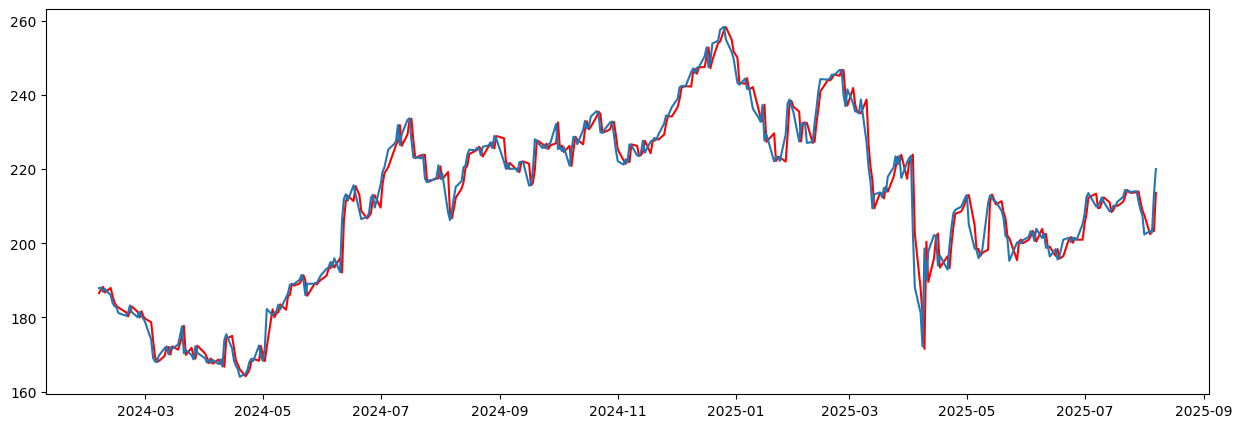

In [ ]:
plt.clf()
plt.figure(figsize=(15,5))
plt.plot(dates[train_split:], predictions, label='Pred', color ="red")
plt.plot(dates[train_split:], history[train_split:])
plt.show()

Best AIC for ARIMA was 4198.8 at p,d,q = (4,1,2)

![alt text](image-2.png)


![alt text](image-1.png)

*SARIMA*

In [ ]:
predictions = []

history = list(train)

print("Started...")

for i in range(len(test)):
    if i %50 == 0:
        print(f"Step: {i}")
    sarima_model = ARIMA(history, order=(p,d,q), seasonal_order=(1,1,1,12))
    sarima_modeled = sarima_model.fit()
    predictions.append(sarima_modeled.forecast(steps=1)[0])
    history.append(test[i])



Started...
Step: 0
Step: 50
Step: 100
Step: 150
Step: 200
Step: 250
Step: 300
Step: 350


ValueError: operands could not be broadcast together with shapes (879,) (377,) 

Error: 2.145509358411444


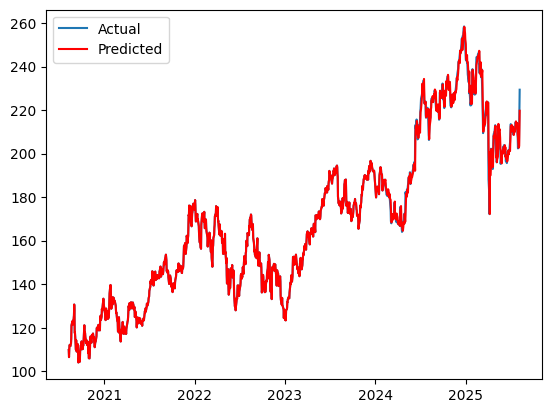

In [12]:
pred = list(close_prices[:train_split]) + list(inv_boxcox(predictions,lam))

rmse = sqrt(mean_squared_error(close_prices, pred))
print(f"Error: {rmse}")

plt.clf()

plt.plot(dates, close_prices, label='Actual')
plt.plot(dates, pred, label='Predicted', color='red')
plt.legend()
plt.show()

*SARIMAX*

In [19]:
msftTicker = yfinance.Ticker('MSFT')
msft_data = msftTicker.history(period='5y')
msft_df = pd.DataFrame(msft_data)
msft_df = msft_df.reset_index().dropna()
msft_close_prices = np.array(df['Close'])

GOGLTicker = yfinance.Ticker('GOGL')
GOGL_data = GOGLTicker.history(period='5y')
GOGL_df = pd.DataFrame(GOGL_data)
GOGL_df = GOGL_df.reset_index().dropna()
GOGL_close_prices = np.array(df['Close'])


In [21]:
addPrices = np.column_stack((msft_close_prices[:train_split],GOGL_close_prices[:train_split]))
futureAddPrices = np.column_stack((msft_close_prices[train_split:],GOGL_close_prices[train_split:]))

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

predictions = []

history = list(train)

print("Started...")


sarimax_model = SARIMAX(history, order=(p,d,q), seasonal_order=(1,1,1,12), exog=addPrices)
sarimax_modeled = sarimax_model.fit()


Started...


In [26]:
forecast = sarima_modeled.forecast(steps=len(test), exog=futureAddPrices)

Error: 35.70395672413526


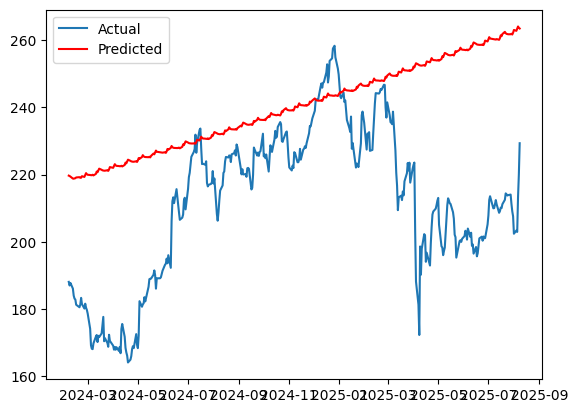

In [28]:
pred = list(inv_boxcox(forecast,lam))

rmse = sqrt(mean_squared_error(close_prices[train_split:], pred))
print(f"Error: {rmse}")

plt.clf()

plt.plot(dates[train_split:], close_prices[train_split:], label='Actual')
plt.plot(dates[train_split:], pred, label='Predicted', color='red')
plt.legend()
plt.show()